## **Objetivo del Proyecto**

El objetivo de esta investigación es contribuir a la reducción de los índices delictivos en las comunas más afectadas de la Ciudad Autónoma de Buenos Aires. Para ello, se busca identificar patrones temporales y geográficos en la ocurrencia de delitos que permitan una mejor asignación de recursos, como la distribución de personal policial y la instalación de cámaras de seguridad en zonas críticas.

A través del análisis de datos históricos correspondientes a los años 2021, 2022 y 2023, se pretende responder las siguientes preguntas:

* ¿Aumentaron o disminuyeron los delitos en los últimos años?

* ¿Cuáles son las comunas con mayor cantidad de delitos?

* ¿Qué tipo de delito es el más frecuente?

* ¿En qué franjas horarias se concentran más delitos?

Estos hallazgos permitirán construir un modelo predictivo que anticipe la cantidad de delitos por comuna, día y franja horaria, con el fin de tomar decisiones informadas y prevenir futuros incidentes.



## **Importación**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor


# cargar los archivos
df_2021 = pd.read_excel("delitos_2021.xlsx", engine='openpyxl')
df_2022 = pd.read_excel("delitos_2022.xlsx", engine='openpyxl')
df_2023 = pd.read_excel("delitos_2023.xlsx", engine='openpyxl')

In [2]:
df_total = pd.concat([df_2021, df_2022, df_2023], ignore_index=True)

In [3]:
print(df_total.head())

    id-mapa  anio      mes  dia      fecha  franja   tipo      subtipo  \
0  110639.0  2021  octubre  MIE 2021-10-06     0.0  Hurto  Hurto total   
1  110640.0  2021  octubre  JUE 2021-10-07    23.0   Robo   Robo total   
2  110641.0  2021  octubre  MIE 2021-10-06    12.0   Robo   Robo total   
3  110642.0  2021  octubre  JUE 2021-10-07    20.0   Robo   Robo total   
4  110643.0  2021  octubre  SAB 2021-10-09    11.0  Hurto  Hurto total   

  uso_arma uso_moto           barrio comuna     latitud    longitud  cantidad  \
0       NO       NO  VELEZ SARSFIELD   10.0 -34631129.0 -58489377.0         1   
1       NO       NO  VELEZ SARSFIELD   10.0 -34624628.0 -58501039.0         1   
2       SI       NO     MONTE CASTRO   10.0 -34623213.0 -58510132.0         1   
3       NO       NO  VELEZ SARSFIELD   10.0 -34627172.0 -58498928.0         1   
4       NO       NO         FLORESTA   10.0 -34626978.0 -58483313.0         1   

   id-sum  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     Na

## **Limpieza de datos**

In [4]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410341 entries, 0 to 410340
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id-mapa   252880 non-null  float64       
 1   anio      410341 non-null  int64         
 2   mes       410341 non-null  object        
 3   dia       410341 non-null  object        
 4   fecha     410341 non-null  datetime64[ns]
 5   franja    408554 non-null  float64       
 6   tipo      410341 non-null  object        
 7   subtipo   410341 non-null  object        
 8   uso_arma  410341 non-null  object        
 9   uso_moto  410341 non-null  object        
 10  barrio    404684 non-null  object        
 11  comuna    404698 non-null  object        
 12  latitud   402558 non-null  object        
 13  longitud  402558 non-null  object        
 14  cantidad  410341 non-null  int64         
 15  id-sum    157461 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int6

In [5]:
df_total.shape

(410341, 16)

In [6]:
df_total.duplicated().sum()

np.int64(0)

In [ ]:
df_total.isnull().sum()

In [8]:
 #elimino columnas con muchos nulos y que no voy a utilizar
df_total = df_total.drop(columns=['id-sum', 'id-mapa', 'latitud', 'longitud'])

In [9]:
df_total.dropna(inplace=True) #elimino las filas con nulos

In [ ]:
df_total.isnull().sum() #verifico que no queden nulos

In [11]:
print(df_total['cantidad'].value_counts())
print(df_total['cantidad'].unique())

cantidad
1    403175
Name: count, dtype: int64
[1]


In [ ]:
print(df_total['comuna'].value_counts()) #la columna comuna tiene varias formas de llamar a una comuna

In [13]:
#normalizo el nombre de las comunas
df_total['comuna_num'] = (
    df_total['comuna']
        .astype(str)                # convierte todo a string
        .str.extract(r'(\d+)')      # saca los números
        .astype('Int64')            # enteros que aceptan NA
)


In [ ]:
df_total['comuna_num'].value_counts(dropna=False) #verifico que se hayan renombrado correctamente las comunas

In [15]:
df_total = df_total.dropna(subset=['comuna_num']) # eliminamos nulos


In [ ]:
df_total.shape
df_total['comuna_num'].isna().sum()

## **Exploración de datos (EDA)**

### **Gráficos**


### ***Cantidad de delitos por año***

C:\Users\shana\AppData\Local\Temp\ipykernel_7576\1217609540.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=delitos_por_anio, x='anio', y='cantidad', palette='viridis')


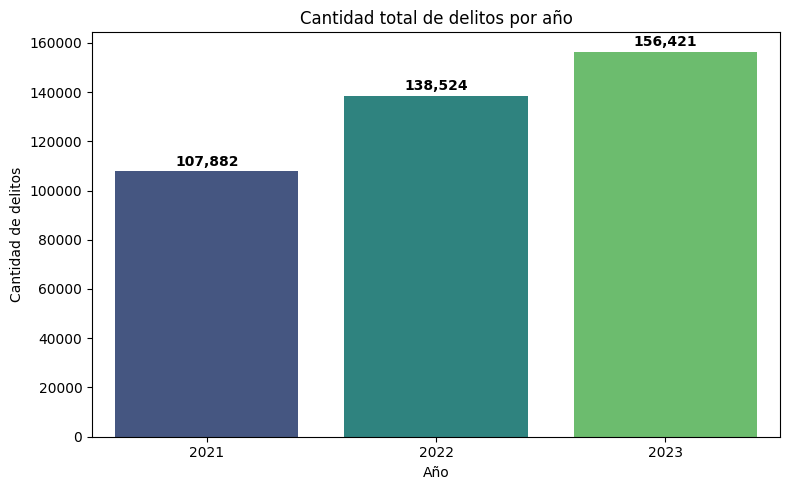

In [17]:
delitos_por_anio = df_total.groupby('anio')['cantidad'].sum().reset_index()

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=delitos_por_anio, x='anio', y='cantidad', palette='viridis')

# Agregar los valores encima de cada barra
for i, row in delitos_por_anio.iterrows():
    ax.text(i, row['cantidad'] + 1000, f"{int(row['cantidad']):,}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Cantidad total de delitos por año")
plt.ylabel("Cantidad de delitos")
plt.xlabel("Año")
plt.tight_layout()
plt.show()

Se puede observar que en el periodo de 2021 - 2023 hubo un aumento de delitos.

### ***Comunas con mayor cantidad de delitos***

C:\Users\shana\AppData\Local\Temp\ipykernel_7576\2492273954.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top10, x='comuna_num', y='total_delitos', palette='viridis', order=orden_comunas_top10)


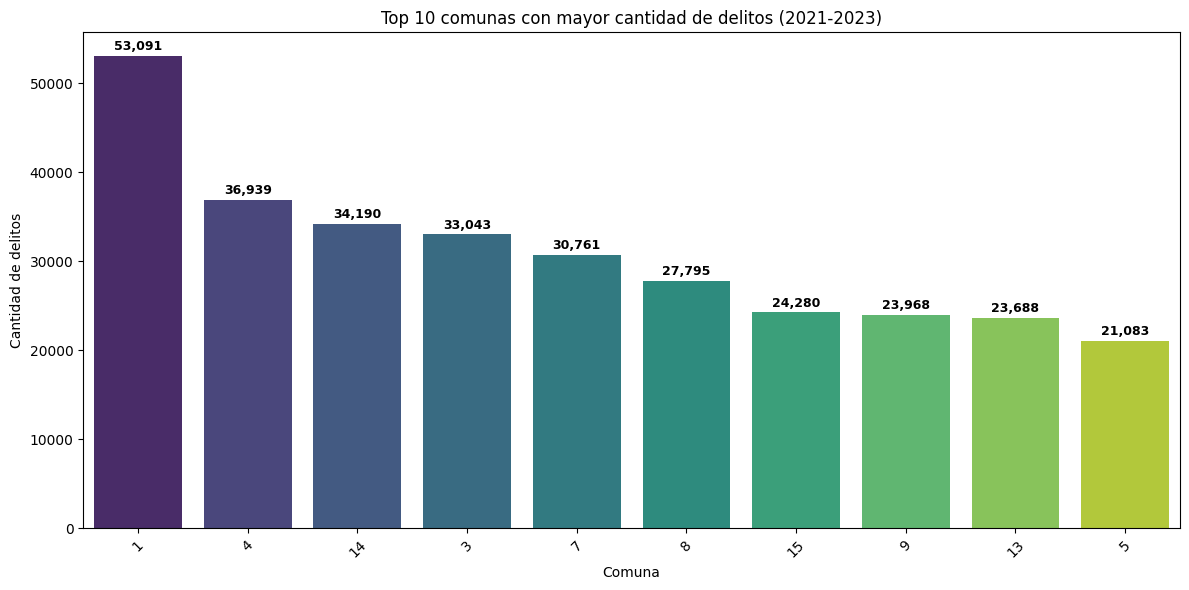

In [18]:
# Agrupar por comuna y contar delitos
delitos_por_comuna = df_total.groupby('comuna_num').size().reset_index(name='total_delitos')

# Ordenar por total de delitos (de mayor a menor)
delitos_por_comuna = delitos_por_comuna.sort_values(by='total_delitos', ascending=False)

# Quedarse con las 10 comunas con más delitos
top10 = delitos_por_comuna.head(10)

# Convertir comuna a string para evitar floats en el gráfico
#top10['comuna'] = top10['comuna'].astype(int)

# Obtener orden
orden_comunas_top10 = top10['comuna_num'].tolist()

# Gráfico
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top10, x='comuna_num', y='total_delitos', palette='viridis', order=orden_comunas_top10)

# Agregar texto encima de cada barra
for i, row in top10.iterrows():
    ax.text(x=orden_comunas_top10.index(row['comuna_num']),
            y=row['total_delitos'] + 300,
            s=f"{row['total_delitos']:,}",
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('Top 10 comunas con mayor cantidad de delitos (2021-2023)')
plt.xlabel('Comuna')
plt.ylabel('Cantidad de delitos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


La comuna 1 tiene una gran diferencia en cantidad de delitos con un total de 53031 casos, en segundo lugar está la comuna 4 con 36939 casos. Las demás comunas oscilan en los 34000 y 21000 casos.

### ***Distribución por tipo de delito***

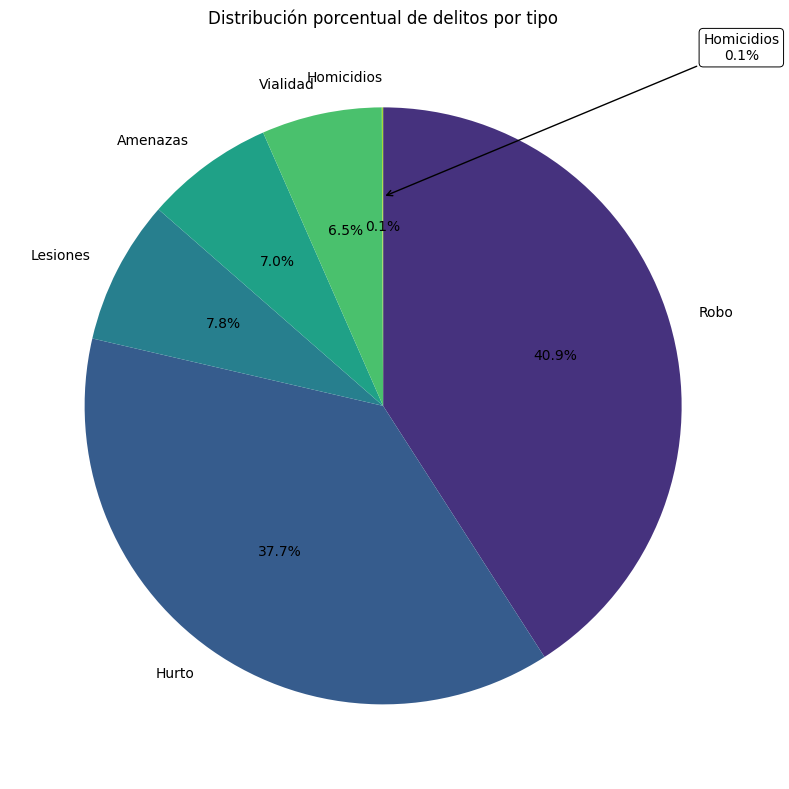

In [19]:
# Agrupar por tipo de delito
delitos_por_tipo = df_total['tipo'].value_counts()

# Etiquetas y valores
labels = delitos_por_tipo.index
sizes = delitos_por_tipo.values

# Usar la paleta viridis con tantos colores como tipos de delito
colors = sns.color_palette("viridis", len(labels))

# Crear gráfico
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    textprops=dict(color="black"),
    colors=colors  # <- aplicamos la paleta viridis
)

# Título
plt.title('Distribución porcentual de delitos por tipo')

# Agregar anotación con flecha para el porcentaje pequeño ("Homicidios")
for i, label in enumerate(labels):
    if label == "Homicidios":
        ang = (wedges[i].theta2 + wedges[i].theta1) / 2.
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))

        ax.annotate(
            f"Homicidios\n{sizes[i] / sizes.sum() * 100:.1f}%",
            xy=(x * 0.7, y * 0.7),         # punto sobre el gráfico
            xytext=(1.2, 1.2),             # punto donde va el texto
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color='black'),
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.7),
            ha='center', va='center'
        )
        break

# Mostrar gráfico
plt.tight_layout()
plt.show()

Podemos observar que un 70% de los delitos son robos o hurtos, mientras que solo un 0.1% se trata de homicidios.

### ***Franjas horarias con mayor cantidad de delitos***

C:\Users\shana\AppData\Local\Temp\ipykernel_7576\368840741.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15_franjas.index.astype(str), y=top_15_franjas.values, palette='viridis')


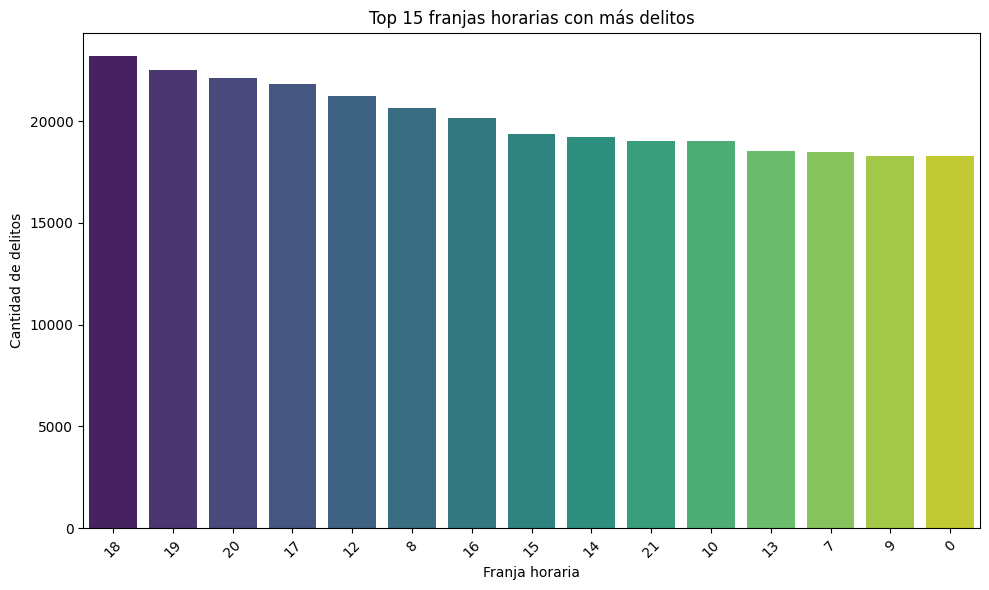

In [20]:
df_total['franja'] = df_total['franja'].astype(int)

# Agrupar por franja horaria y sumar la cantidad de delitos
franjas = df_total.groupby('franja')['cantidad'].sum().sort_index()

#top_10 = franjas.head(12)
top_15_franjas = franjas.sort_values(ascending=False).head(15)


# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=top_15_franjas.index.astype(str), y=top_15_franjas.values, palette='viridis')

plt.title('Top 15 franjas horarias con más delitos')
plt.xlabel('Franja horaria')
plt.ylabel('Cantidad de delitos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ***Cantidad de delitos por franja horaria***

C:\Users\shana\AppData\Local\Temp\ipykernel_7576\137788720.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=franjas.index, y=franjas.values, palette='viridis')


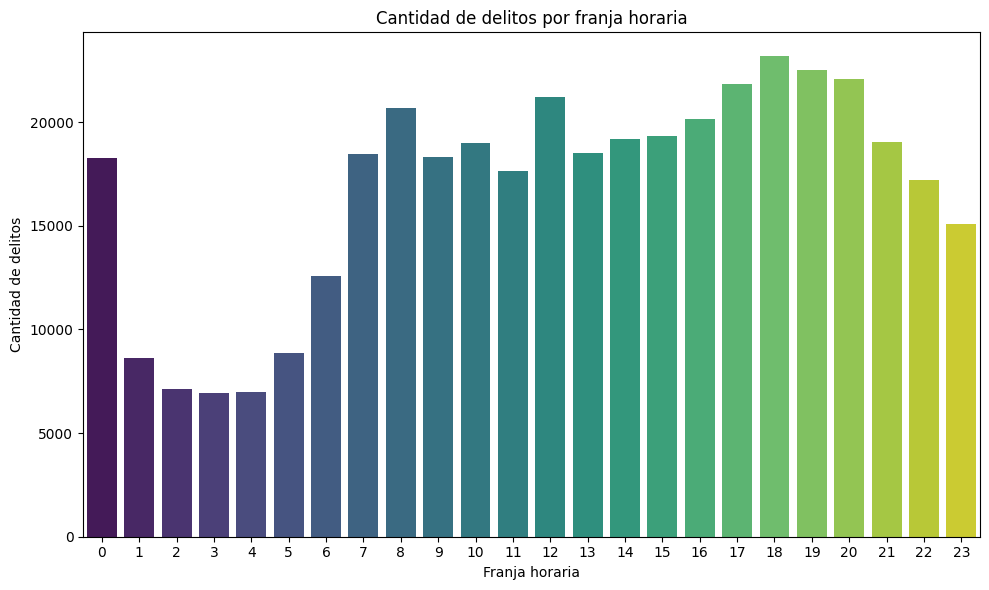

In [21]:
# Agrupar por franja horaria y sumar la cantidad de delitos
franjas = df_total.groupby('franja')['cantidad'].sum().sort_index()

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=franjas.index, y=franjas.values, palette='viridis')

plt.title('Cantidad de delitos por franja horaria')
plt.xlabel('Franja horaria')
plt.ylabel('Cantidad de delitos')
plt.xticks(franjas.index)  # asegurar que se muestren todos los ticks

plt.tight_layout()
plt.show()

Las franjas con mayor indice delictivo se encuentra entre las 17hs y las 20hs, mientras que las franjas con menor indice delictivo son entre la 1am y las 4am.

In [22]:
#cantidad de delitos por franja y comuna
pd.pivot_table(
    df_total,
    values='cantidad',
    index='franja',
    columns='comuna_num',
    aggfunc='sum'
)

comuna_num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
franja,,,,,,,,,,,,,,,
0,2547,731,1426,1760,1020,638,1331,1472,981,875,746,819,1103,1602,1226
1,1238,336,665,847,491,340,559,576,517,386,391,372,426,911,556
2,1065,351,507,675,367,270,508,431,375,323,296,291,293,906,463
3,1025,323,457,673,340,235,505,385,371,272,257,254,316,1048,465
4,1133,305,455,700,316,199,537,478,349,264,231,213,274,1120,387
5,1342,312,618,982,410,242,736,885,575,309,338,267,316,1060,455
6,1627,440,865,1434,631,401,1113,1225,959,622,565,440,449,1118,703
7,1963,710,1200,1837,960,846,1750,1505,1442,1043,1096,919,840,1310,1050
8,2164,742,1360,1972,1129,1000,1825,1460,1469,1114,1265,1267,1124,1392,1385


### ***Conclusión EDA***

El análisis exploratorio de los datos del período 2021–2023 evidencia un incremento en la cantidad total de delitos a lo largo del tiempo. A nivel espacial, la comuna 1 concentra significativamente más delitos que el resto, seguida por la comuna 4, mientras que las demás comunas presentan volúmenes relativamente similares.

En cuanto al tipo de delito, se observa que la gran mayoría de los casos corresponden a robos y hurtos, representando alrededor del 70% del total, mientras que los homicidios constituyen una proporción mínima. Desde el punto de vista temporal, los picos de actividad delictiva se concentran en franjas horarias de alta circulación de personas, especialmente entre las 17 y las 20 horas, y se registran menores niveles durante la madrugada.

En conjunto, el EDA revela patrones espaciales y temporales claros, aunque con una alta variabilidad interna, lo que sugiere la influencia de factores no observados y establece un límite natural al poder explicativo de los modelos predictivos desarrollados posteriormente.

## **Feature Engineering**

Con el objetivo de mejorar los resultados del entrenamiento de los modelos de machine learning,
se construyen variables temporales y espaciales para capturar patrones de comportamiento
delictivo asociados al tiempo y a la ubicación.

- Se agrega la variable `fin_de_semana` para capturar diferencias entre días laborales y no laborales.
- La variable objetivo `cantidad` se obtiene como el conteo de delitos por combinación de tiempo y espacio mediante operaciones de agrupamiento.
- Durante la limpieza de datos se detectó una doble nomenclatura en la variable comuna, por lo que se unificaron los valores para garantizar consistencia.
- Se renombró la variable `dia` a `dia_semana`, ya que originalmente no quedaba claro si hacía referencia al día del mes o al día de la semana.

Finalmente, se construyó el dataset de modelado utilizando las variables
`anio`, `mes`, `dia_semana`, `fin_de_semana`, `franja` y `comuna_num`,
agrupadas en función de la cantidad de delitos.

In [23]:
df_total = df_total.rename(columns={'dia': 'dia_semana'})

In [24]:
df_total['fin_de_semana'] = df_total['dia_semana'].isin([5, 6]).astype(int)

In [26]:
df_total['mes'] = df_total['mes'].map({
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4,
    'mayo': 5, 'junio': 6, 'julio': 7, 'agosto': 8,
    'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12
})

In [27]:
df_total['dia_semana'] = df_total['dia_semana'].map({
    'LUN': 0, 'MAR': 1, 'MIE': 2, 'JUE': 3, 'VIE': 4, 'SAB': 5, 'DOM':6
})

In [ ]:
print(df_total.head())

In [29]:
#creamos el df para el  modelado
df_model = (
    df_total
    .groupby(['anio', 'mes', 'dia_semana', 'fin_de_semana', 'franja', 'comuna_num'])
    .size()
    .reset_index(name='cantidad')
)
df_model.head()


,anio,mes,dia_semana,fin_de_semana,franja,comuna_num,cantidad
0,2021,1,0,0,0,1,11
1,2021,1,0,0,0,2,1
2,2021,1,0,0,0,3,4
3,2021,1,0,0,0,4,5
4,2021,1,0,0,0,5,2


In [ ]:
df_model.info()
df_model.head()

<Axes: xlabel='comuna_num', ylabel='cantidad'>

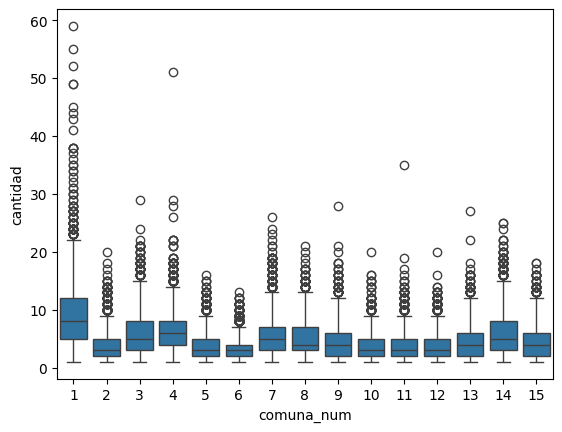

In [31]:
sns.boxplot(x='comuna_num', y='cantidad', data=df_model) #grafico cantidad de delitos por comuna

La presencia de colas largas y outliers en la distribución de la cantidad de delitos indica la existencia de eventos extremos poco frecuentes. Esta asimetría contribuye a la alta variabilidad del target y limita la capacidad del modelo para predecir con precisión los valores más elevados.

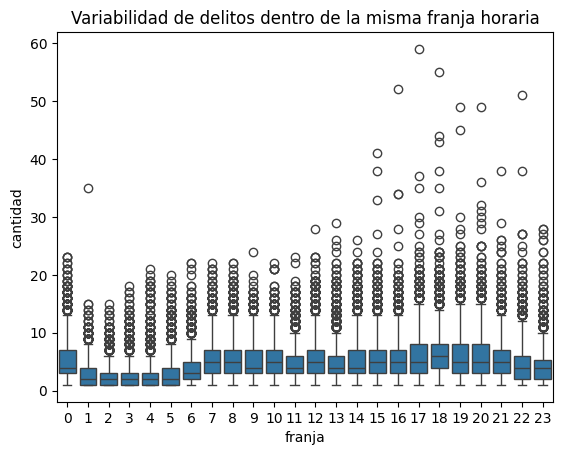

In [32]:
#grafico cantidad de delitos por franja
sns.boxplot(x='franja', y='cantidad', data=df_model)
plt.title("Variabilidad de delitos dentro de la misma franja horaria")
plt.show()

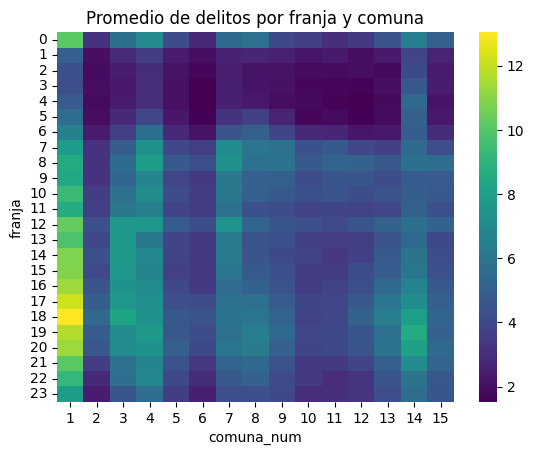

In [33]:
pivot = pd.pivot_table(
    df_model,
    values='cantidad',
    index='franja',
    columns='comuna_num',
    aggfunc='mean'
)

sns.heatmap(pivot, cmap='viridis')
plt.title("Promedio de delitos por franja y comuna")
plt.show()

Con este mapa de calor podemos ver como la mayor concentración de casos ocurre cerca de las 18hs en la comuna 1.

## **Entrenamiento de Modelos**

In [34]:
features = [
    'anio',
    'mes',
    'dia_semana',
    'fin_de_semana',
    'franja',
    'comuna_num'
]

X = df_model[features]
y = df_model['cantidad']

In [ ]:
X.isna().sum() #verificamos nulos

In [ ]:
y.describe()

### **Modelo base - Regresión lineal**

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [38]:
baseline = LinearRegression()
baseline.fit(X_train, y_train)

LinearRegression()

In [39]:
y_pred_base = baseline.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_base))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R2:", r2_score(y_test, y_pred_base))

MAE: 2.3338881949931087
RMSE: 3.074091414068654
R2: 0.11439355439539889


Entrenamos un modelo de regesión lineal como modelo base para tener un punto de partidad de referencia. Se obtuvo un bajo rendimiento, el modelo solo puede explicar un 11% de la variabilidad de los datos ya que estos no son lineales.

### **Random Forest Regressor**

In [40]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [41]:
y_pred_rf = rf.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))

MAE: 1.7860972978189278
RMSE: 2.364335219749562
R2: 0.47612784400842756


In [43]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)

comuna_num       0.379355
franja           0.299270
anio             0.109558
dia_semana       0.108695
mes              0.103121
fin_de_semana    0.000000
dtype: float64

In [44]:
r2_train = r2_score(y_train, rf.predict(X_train))
r2_test = r2_score(y_test, rf.predict(X_test))

In [45]:
print(r2_test)
print(r2_test)

0.47612784400842756
0.47612784400842756


In [46]:
scores = cross_val_score(
    rf, X, y,
    cv=5,
    scoring='r2'
)

print("R2 por fold:", scores)
print("R2 promedio:", scores.mean())


R2 por fold: [0.2575804  0.32095347 0.43269806 0.38373258 0.42200279]
R2 promedio: 0.3633934600702773


En el entrenamiento del modelo de Random Forest Regressor se obtuvieron mejores resultados con un R2 cercano a 0.48. Al utilizar la validación cruzada llegamos a un R2 de 0.36, por lo que el modelo es capaz de capturar los patrones espaciales y temporales relevantes.

### **Random Forest Regressor Ajustado**

In [47]:
rf2 = RandomForestRegressor(
    n_estimators=400,
    max_depth=16,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf2.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, min_samples_leaf=5, n_estimators=400,
                      n_jobs=-1, random_state=42)

In [48]:
y_pred_rf2 = rf2.predict(X_test)

mae_rf2 = mean_absolute_error(y_test, y_pred_rf2)
rmse_rf2 = np.sqrt(mean_squared_error(y_test, y_pred_rf2))
r2_rf2 = r2_score(y_test, y_pred_rf2)

print("MAE:", mae_rf2)
print("RMSE:", rmse_rf2)
print("R2:", r2_rf2)

MAE: 1.7631145108495871
RMSE: 2.3330958756799043
R2: 0.4898799603460927


In [49]:
scores_rf2 = cross_val_score(
    rf2,
    X,
    y,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

print("R2 por fold:", scores_rf2)
print("R2 promedio:", scores_rf2.mean())
print("Desvío:", scores_rf2.std())

R2 por fold: [0.28523448 0.33867673 0.44207866 0.38482087 0.43612133]
R2 promedio: 0.3773864138233928
Desvío: 0.05946522755282113


In [50]:
importances_rf2 = pd.Series(
    rf2.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances_rf2


comuna_num       0.359803
franja           0.301647
mes              0.124720
dia_semana       0.110876
anio             0.102954
fin_de_semana    0.000000
dtype: float64

El ajuste de hiperparámetros del Random Forest permitió mejorar levemente el desempeño y la estabilidad del modelo. Se observa una reducción adicional del MAE y RMSE, así como un incremento del R2 en test (0.49) y en validación cruzada (0.38). Esto indica una mejor capacidad de generalización y un control más adecuado del sobreajuste, consolidando al Random Forest ajustado como una versión más robusta del modelo anterior.

### **Gradient Boosting**

In [51]:
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

gbr.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=300,
                          random_state=42, subsample=0.8)

In [52]:
y_pred = gbr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Gradient Boosting - Test")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

Gradient Boosting - Test
MAE: 1.7880664245614917
RMSE: 2.3875895322893603
R2: 0.46577212464105866


In [53]:
scores = cross_val_score(
    gbr, X, y,
    cv=5,
    scoring='r2'
)

print("R2 por fold:", scores)
print("R2 promedio:", scores.mean())
print("Desvío:", scores.std())

R2 por fold: [0.31037502 0.37780518 0.42991003 0.43382217 0.42953828]
R2 promedio: 0.3962901374629915
Desvío: 0.04768121346178613


In [54]:
importances = pd.Series(
    gbr.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances

comuna_num       0.449059
franja           0.318742
anio             0.108970
dia_semana       0.072899
mes              0.050330
fin_de_semana    0.000000
dtype: float64

El desempeño del modelo Gradient Boosting fue positivo, siendo que este puede explicar en un 46% la variabilidad de los datos predichos respecto a los datos reales. También a partir de la validación cruzada se puede observar una mejora en cuanto a los folds. 

### **XGBRegressor**

In [55]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

In [56]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

In [57]:
y_pred = xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("XGBoost - Test")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

XGBoost - Test
MAE: 1.746930480003357
RMSE: 5.413827419281006
R2: 0.4926453232765198


In [58]:
scores = cross_val_score(
    xgb, X, y,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

print("R2 por fold:", scores)
print("R2 promedio:", scores.mean())
print("Desvío:", scores.std())

R2 por fold: [0.31850487 0.38377053 0.44861281 0.44057173 0.44832122]
R2 promedio: 0.40795623064041137
Desvío: 0.05085775215426431


In [59]:
importances = pd.Series(
    xgb.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances

comuna_num       0.409576
franja           0.248865
anio             0.190508
dia_semana       0.084560
mes              0.066492
fin_de_semana    0.000000
dtype: float32

XGBoost es el modelo que alcanza el mejor balance general entre desempeño y capacidad de generalización. Tiene el menor MAE, el R2 más alto en el conjunto de test 0.49 y el mejor R2 promedio en validación cruzada de 0.41. Esto indica que el modelo captura de manera más eficiente las relaciones complejas entre las variables espacio-temporales y la cantidad de delitos, manteniendo una buena estabilidad entre distintos subconjuntos de datos. Por este motivo, XGBoost es elegido como el modelo final del proyecto.

### ***Conclusiones***

En conjunto, los resultados muestran que los modelos basados en árboles superan ampliamente al modelo de regresión lineal. A medida que se incorporan técnicas de ensamble más complejas, se logra una mejora progresiva tanto en desempeño como en estabilidad. Sin embargo, el R2 alcanzado refleja también las limitaciones inherentes del fenómeno analizado, ya que tiene una alta variabilidad y la influencia de factores no observados.

## **Próximos pasos**

Como trabajo futuro, sería relevante ampliar el período temporal del dataset incorporando años más recientes, lo que permitiría evaluar la estabilidad de los patrones detectados y mejorar la capacidad de generalización de los modelos.

Asimismo, se propone integrar visualizaciones geoespaciales, como mapas de calor por comuna y franja horaria, con el objetivo de identificar zonas y momentos de mayor concentración de delitos. Este tipo de análisis podría aportar valor desde una perspectiva exploratoria y facilitar la comunicación de resultados a actores no técnicos.